This notebook aims to conduct feature engineering for our PD Model. We will be selecting features, and conducting feature engineering. 

## 0. Import Libraries

In [4]:
# Standard libraries
import os

# Third-party packages
import wandb
from dotenv import load_dotenv

# Local modules
from init_spark import start_spark
spark = start_spark()

load_dotenv()

wandb.login(key=os.getenv("WANDB_API_KEY"))

4.0.0


25/07/21 00:22:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


True

In [5]:
# Pyspark Functions 

# 2. Needed functions for the notebook
from functions import * # Import functions from the functions module

In [6]:

# Remove all runs in the project at the current notebook 
api = wandb.Api()
for run in api.runs(f"wlunlun1212-singapore-management-university/Credit Risk Modeling"):                      
    if run.group == "pd_model_building_2":
        run.delete()

In [7]:
from delta.tables import DeltaTable
from pyspark.sql import SparkSession


# Obtain from Gold Medallion Architecture 
df = spark.read.format("delta")\
    .load("../data/gold/feature_selection_next").cache()
    
df.limit(5).toPandas()

25/07/21 00:22:19 WARN CacheManager: Asked to cache already cached data.


,id,loan_amnt,term,grade,home_ownership,annual_inc,verification_status,issue_d,default_status,pymnt_plan,...,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,credit_history_years,fico_score,proportion_satisfac_accounts,proportion_satisfac_bc_tl
0,46998570,3750.0,36,E,RENT,9479.0,Verified,2015-05-01,0,n,...,0.0,0.0,2.0,100.0,27021.0,11328.0,20.583333,697.0,0.900000,1.500000
1,49037600,9675.0,36,D,OWN,45000.0,Verified,2015-05-01,0,n,...,0.0,0.0,1.0,100.0,52352.0,44743.0,16.166667,687.0,0.900000,0.666667
2,47665387,6050.0,36,B,RENT,15180.0,Verified,2015-05-01,0,n,...,0.0,0.0,0.0,88.9,13700.0,3869.0,7.500000,692.0,0.857143,0.666667
3,47897317,15000.0,36,B,OWN,70000.0,Verified,2015-05-01,0,n,...,0.0,2.0,0.0,62.5,55483.0,2796.0,38.083333,672.0,0.750000,0.500000
4,50043224,20000.0,36,B,MORTGAGE,62628.0,Verified,2015-05-01,0,n,...,0.0,0.0,2.0,90.5,360941.0,34740.0,35.000000,672.0,0.900000,0.750000


In [ ]:
# Audit Trail for feature IV Scores 
import os 
from openpyxl import Workbook


output_dir = "../sandbox/"  # e.g. "/home/username/results"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
output_path = os.path.join(output_dir, "feature_iv_trail.xlsx")

# --- 2. Setup Excel workbook ---
wb = Workbook()
ws = wb.active
ws.title = "IV Scores"
ws.append(["feature", "iv", 'type'])

## 1. Inspect IV Values (Optbinning)
Before feature selection, it is important I understand certain rules I have to adhere to for WoE. 
1) **Monotonicity**: As `feature` bins/values increase, WoE should increase as well. Just like how Logistic Regression Model fits an S-shaped curve, feature and target class should move in the same direction. Else, it violates linearity assumption of Logistic Regression 

2) **No 0 in Good / Bad Counts (Each Bins)**: Required to compute WoE accurately. Prevents division of 0 in WoE calculation 

3) **Group bins of similar WoE together = Coarse binning**

4) **Min 0.5% of good class & bad class in each bin**: Drop if unimportant / Merge 

Additionally, I shall follow the following rules for selecting my features for PD Modeling (Logistic Regression). Ideally, I should have ~ 20 features, that are at least 0.05. As I run IV scoring through features, their IV scores shall be recorded to `sandbox/feature_iv_trail.xlsx`

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

### 1.1.2 Numerical Features WoE & IV Feature Selection 

As manual WoE binning & ensuring monotonicity of WoE for each variable will be extremely tedious, we will be using `optbinning` Python library to conduct WoE binning. This helps us ensure the ultimate IV score obtained is accurate.🚩


🔍 Feature: loan_amnt
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 4237.50)      │    8662 │             0.0798 │ 0.3419091824439615   │ 0.0081306   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4237.50, 7012.50)   │   14492 │             0.0914 │ 0.1927850117197294   │ 0.00458524  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7012.50, 10012.50)  │   19977 │             0.0976 │ 0.12052503322795349  │ 0.00254149  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [10012.50, 12112.50) │    9865 │             0.1166 │ -0.07823249161946588 │ 0.000571557 │
├──────────────────────┼─────────┼──────────────

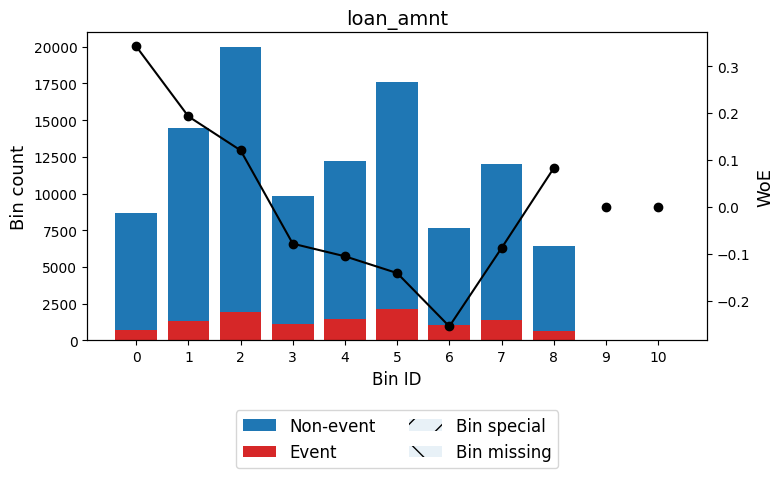

✅ Total IV for loan_amnt: 0.0268

🔍 Feature: term
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │   77528 │             0.0905 │ 0.1936901195994003  │ 0.0247385 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   31424 │             0.1503 │ -0.3818637336854478 │ 0.0487724 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  108952 │          

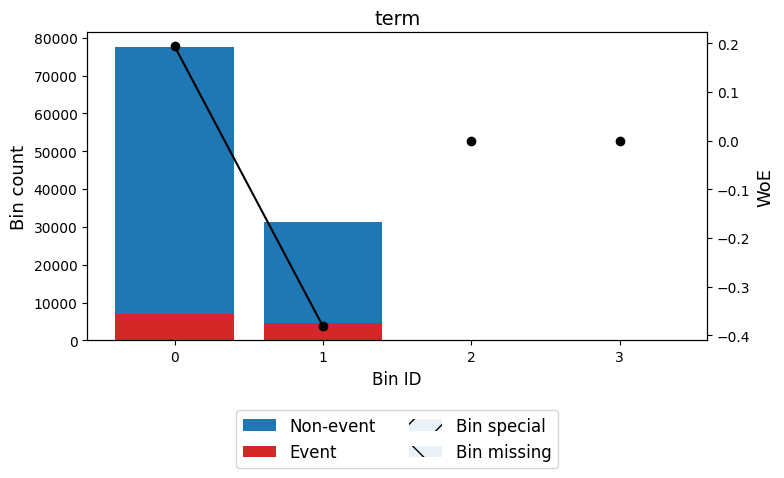

✅ Total IV for term: 0.0735

🔍 Feature: annual_inc
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 45646.00)       │   26168 │             0.1252 │ -0.15900291032790093  │ 0.00646274  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [45646.00, 51694.00)   │    8539 │             0.121  │ -0.12028071764096393  │ 0.00118878  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [51694.00, 56814.50)   │    7174 │             0.1183 │ -0.09531010093191794  │ 0.000621039 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [56814.50, 74634.00)   │   21981 │             0.1134 │ -0.04720414123022598  │ 0.0

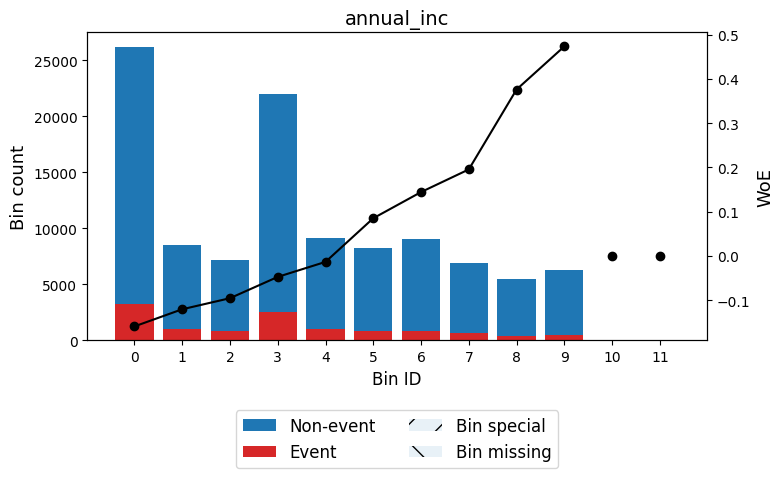

✅ Total IV for annual_inc: 0.0299

🔍 Feature: dti
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 5.04)   │    5642 │             0.0718 │ 0.456100798956657    │ 0.0090124   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.04, 9.61)   │   12475 │             0.079  │ 0.3519727520344378   │ 0.0123603   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9.61, 12.65)  │   12396 │             0.0865 │ 0.25388207638475135  │ 0.00664078  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [12.65, 15.43) │   12750 │             0.0958 │ 0.1407737697315259   │ 0.00219537  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────

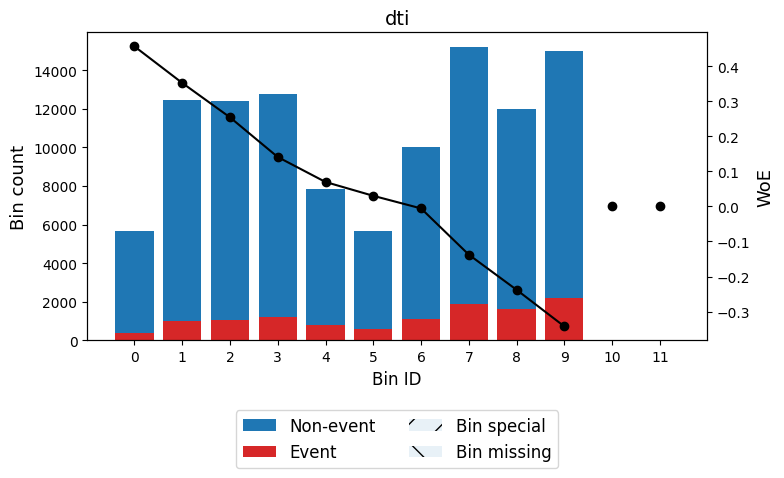

✅ Total IV for dti: 0.0585

🔍 Feature: delinq_2yrs
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   88742 │             0.1042 │ 0.036542389925446894 │ 0.00107216 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   13551 │             0.1175 │ -0.09787671842555046 │ 0.00123805 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, inf)  │    6659 │             0.134  │ -0.2479286029546266  │ 0.00413818 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 

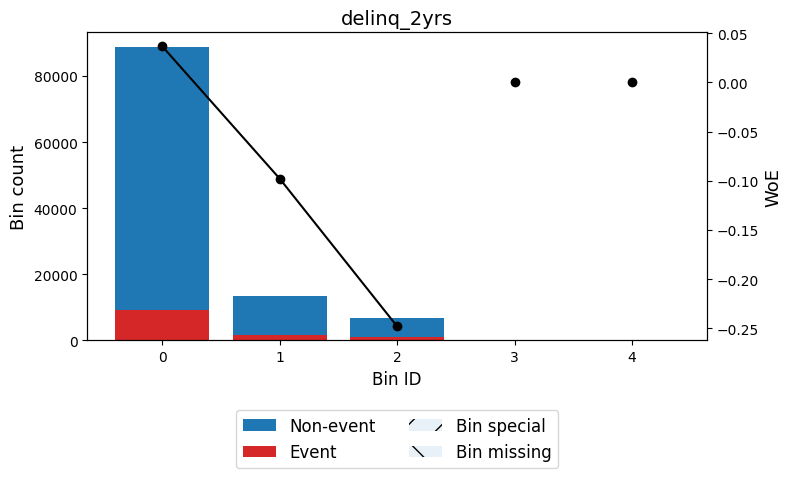

✅ Total IV for delinq_2yrs: 0.0064

🔍 Feature: inq_last_6mths
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   66798 │             0.0906 │ 0.20606133129681536  │ 0.0240471  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   28093 │             0.1253 │ -0.15655731099440828 │ 0.00672666 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, inf)  │   13909 │             0.1651 │ -0.47963430364491777 │ 0.0353648  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing     

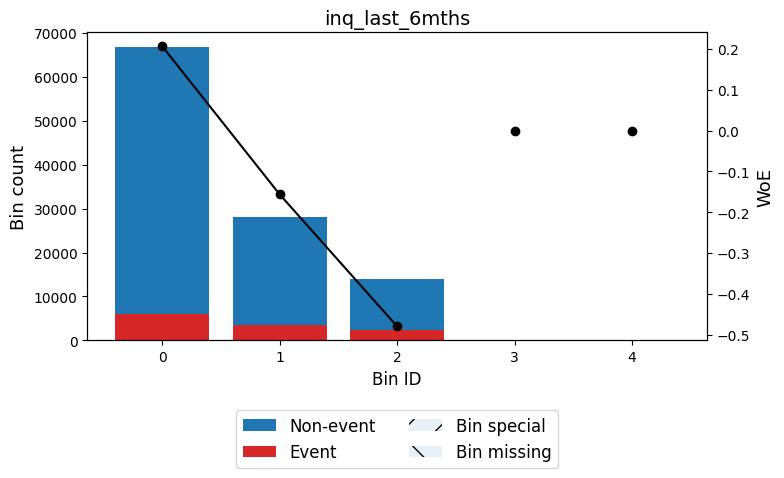

✅ Total IV for inq_last_6mths: 0.0661

🔍 Feature: open_acc
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 5.50)   │   10425 │             0.0784 │ 0.36119604068352507   │ 0.0108384   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 6.50)   │    7010 │             0.0906 │ 0.2029981429176435    │ 0.00244934  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.50, 7.50)   │    8289 │             0.101  │ 0.08289743301571217   │ 0.000506288 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 8.50)   │    8956 │             0.1056 │ 0.03268724279423507   │ 8.67421e-05 │
├────────────────┼─────────┼────────────────────┼────────────

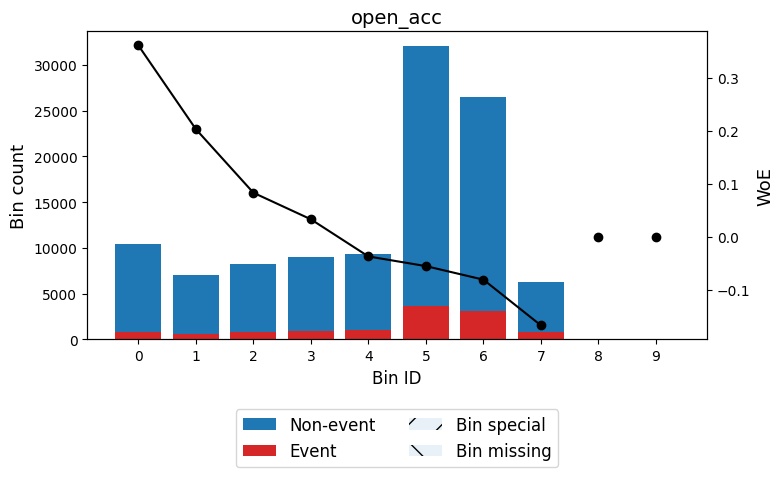

✅ Total IV for open_acc: 0.0183

🔍 Feature: pub_rec
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   91833 │             0.1034 │ 0.04522785119500217  │ 0.00169381 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, inf)  │   17119 │             0.1306 │ -0.21883869729586114 │ 0.00819564 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│              │  108952

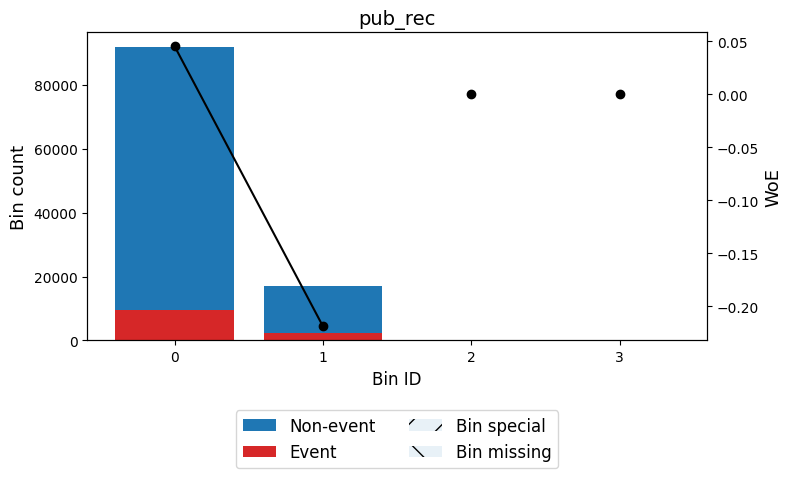

✅ Total IV for pub_rec: 0.0099

🔍 Feature: revol_util
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 9.85)   │    5889 │             0.0644 │ 0.5600474409846883    │ 0.0136188   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9.85, 19.45)  │    7764 │             0.0756 │ 0.38687567152212976   │ 0.00916794  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [19.45, 32.55) │   15339 │             0.0882 │ 0.21899622401317842   │ 0.00619969  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [32.55, 36.85) │    5973 │             0.0981 │ 0.10168787702367554   │ 0.000545106 │
├────────────────┼─────────┼────────────────────┼─────────────────

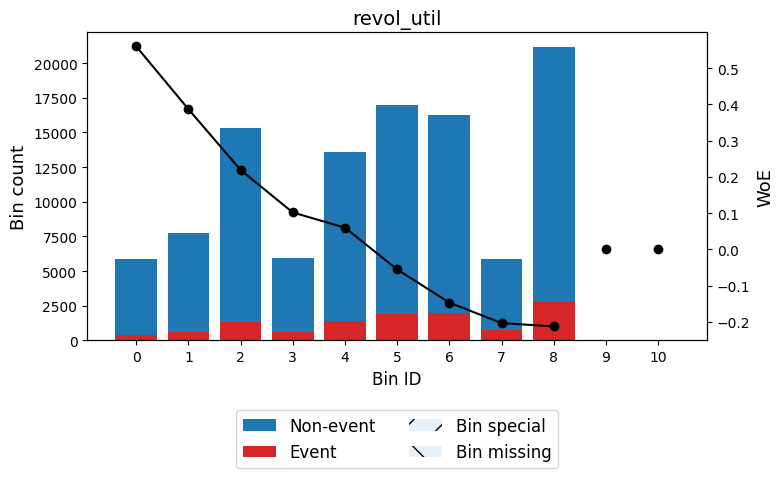

✅ Total IV for revol_util: 0.0459

🔍 Feature: collections_12_mths_ex_med
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  109077 │             0.1081 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  109077 │             0.1081 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


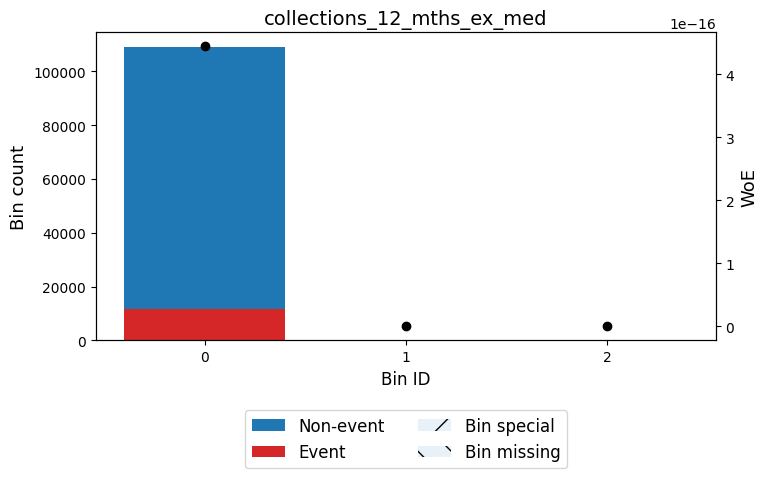

✅ Total IV for collections_12_mths_ex_med: 0.0000

🔍 Feature: acc_now_delinq
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  109077 │             0.1081 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  109077 │             0.1081 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


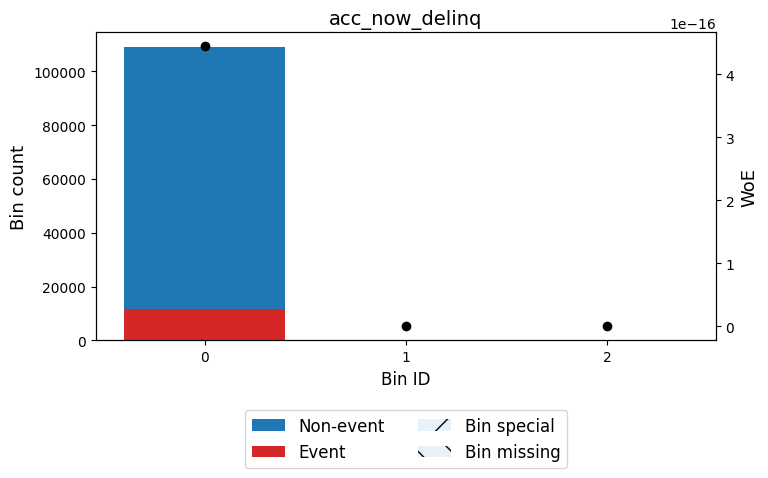

✅ Total IV for acc_now_delinq: 0.0000

🔍 Feature: total_rev_hi_lim
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 9310.00)      │   12188 │             0.1207 │ -0.11762740410473205 │ 0.00162107  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9310.00, 24781.00)  │   38351 │             0.1226 │ -0.1352784241675482  │ 0.0067931   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [24781.00, 25812.50) │    5736 │             0.1342 │ -0.23953677699590914 │ 0.00331683  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [25812.50, 37339.00) │   19055 │             0.1127 │ -0.03980086440839248 │ 0.000281493 │
├──

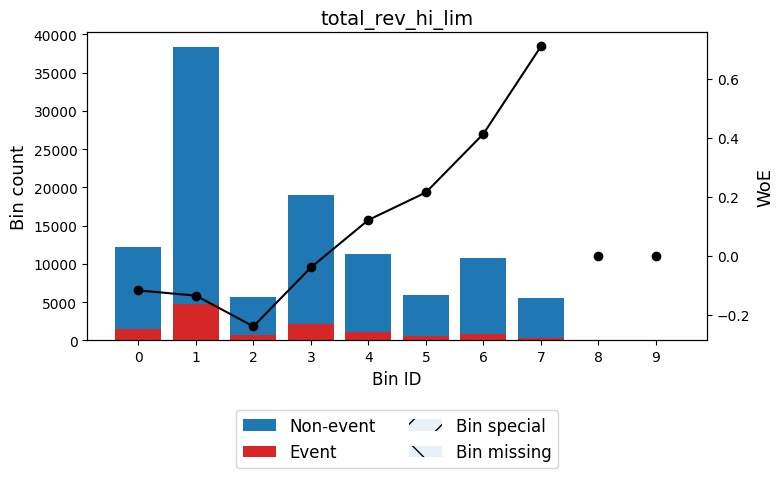

✅ Total IV for total_rev_hi_lim: 0.0496

🔍 Feature: acc_open_past_24mths
╒══════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                    │          IV │
╞══════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, 1.50) │   15594 │             0.068  │ 0.5142422460298364     │ 0.0309681   │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [1.50, 2.50) │   14922 │             0.0785 │ 0.35834755491712755    │ 0.0152934   │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [2.50, 3.50) │   16133 │             0.0945 │ 0.15559533575260565    │ 0.00337536  │
├──────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [3.50, 4.50) │   17099 │             0.1089 │ -0.0019040764082896011 │ 5.69858e-07 │
├──────────────┼─────────┼────────────────────┼──────────

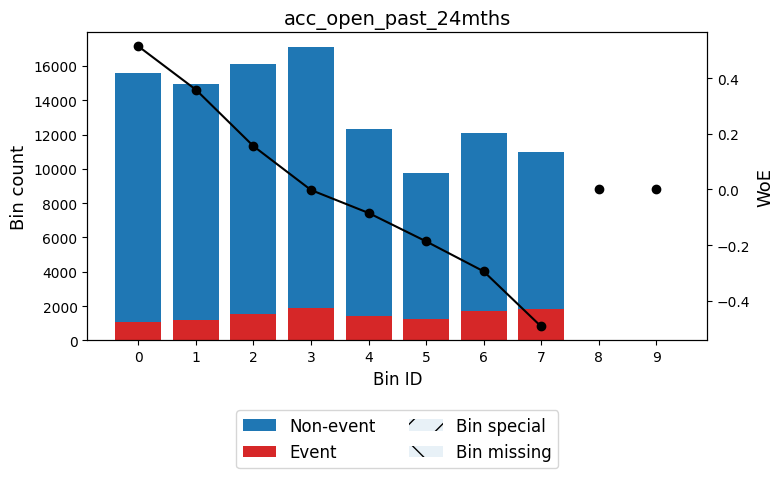

✅ Total IV for acc_open_past_24mths: 0.0940

🔍 Feature: bc_open_to_buy
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 214.50)       │    6151 │             0.1528 │ -0.4040890764346807  │ 0.010791    │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [214.50, 1229.50)    │   14749 │             0.137  │ -0.27652440346584384 │ 0.0115384   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1229.50, 2227.50)   │    9806 │             0.1304 │ -0.21957717891663897 │ 0.00473166  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2227.50, 4123.50)   │   14104 │             0.1233 │ -0.1551765904786122  │ 0.00331489  │

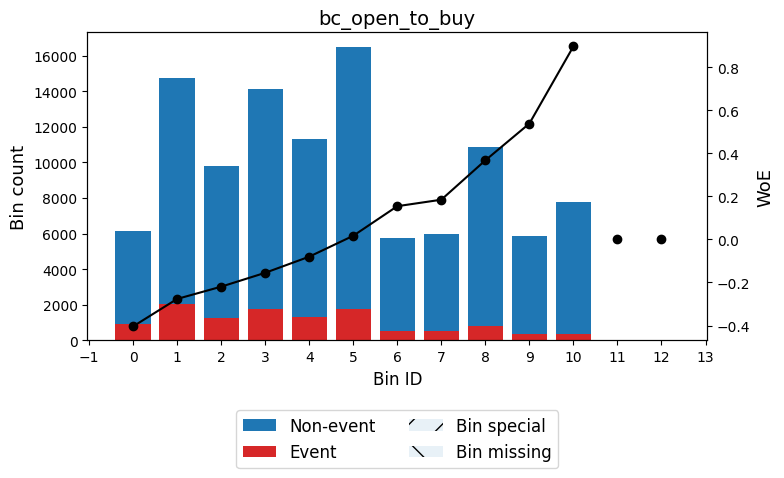

✅ Total IV for bc_open_to_buy: 0.0987

🔍 Feature: chargeoff_within_12_mths
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  109077 │             0.1081 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  109077 │             0.1081 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


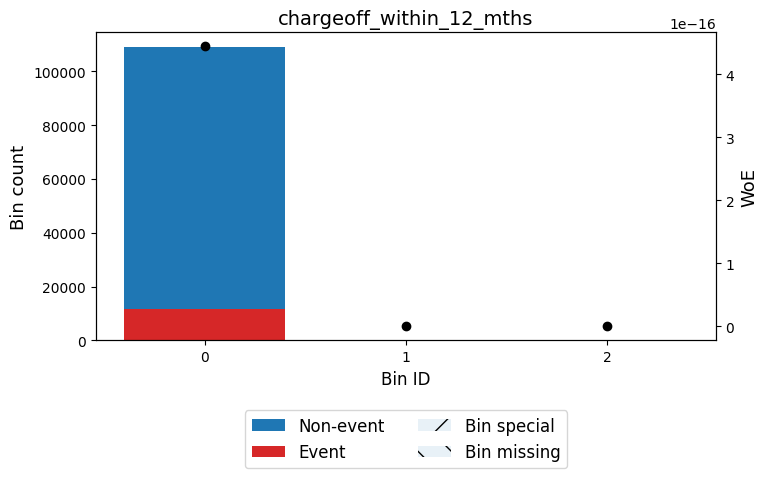

✅ Total IV for chargeoff_within_12_mths: 0.0000

🔍 Feature: delinq_amnt
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  109191 │             0.1088 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  109191 │             0.1088 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


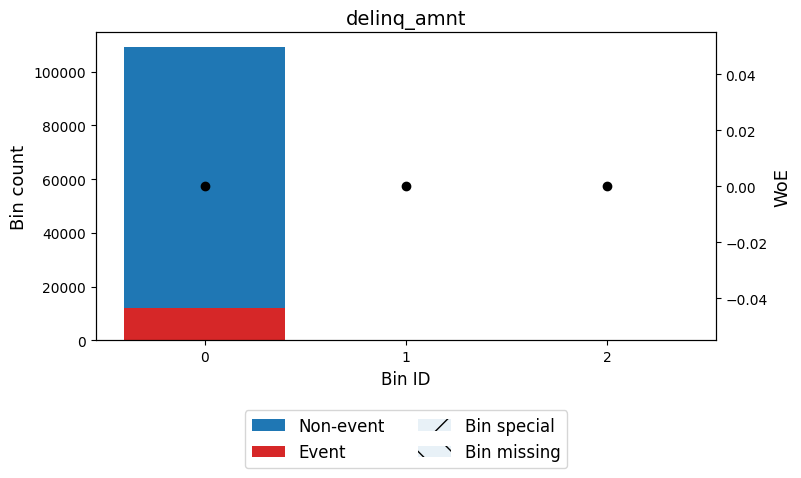

✅ Total IV for delinq_amnt: 0.0000

🔍 Feature: mo_sin_old_il_acct
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 35.50)    │    6001 │             0.1151 │ -0.06430893774797708  │ 0.000233666 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [35.50, 127.50)  │   42092 │             0.1145 │ -0.05828205927700747  │ 0.001343    │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [127.50, 131.50) │   11527 │             0.1125 │ -0.038245553587063164 │ 0.000157141 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [131.50, 136.50) │    5837 │             0.112  │ -0.033484261483783584 │ 6.08798e-05 │
├──────────────────┼─────────┼────

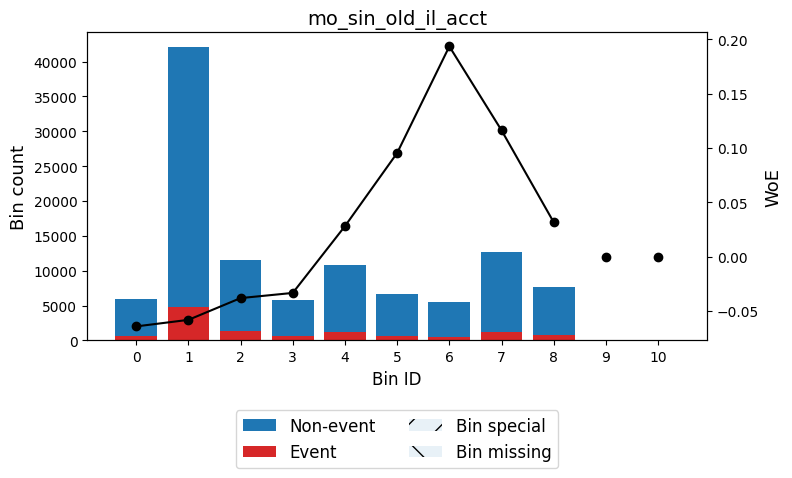

✅ Total IV for mo_sin_old_il_acct: 0.0057

🔍 Feature: mo_sin_rcnt_rev_tl_op
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50)   │    8139 │             0.1458 │ -0.33591595588073164 │ 0.00960448  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 3.50)   │   15982 │             0.1232 │ -0.14105655768519942 │ 0.0030848   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50)   │   13423 │             0.12   │ -0.11125536852945284 │ 0.00159319  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 9.50)   │   22869 │             0.1199 │ -0.11014161210755358 │ 0.00265912  │
├────────────────┼─────────┼────────────────────┼─────

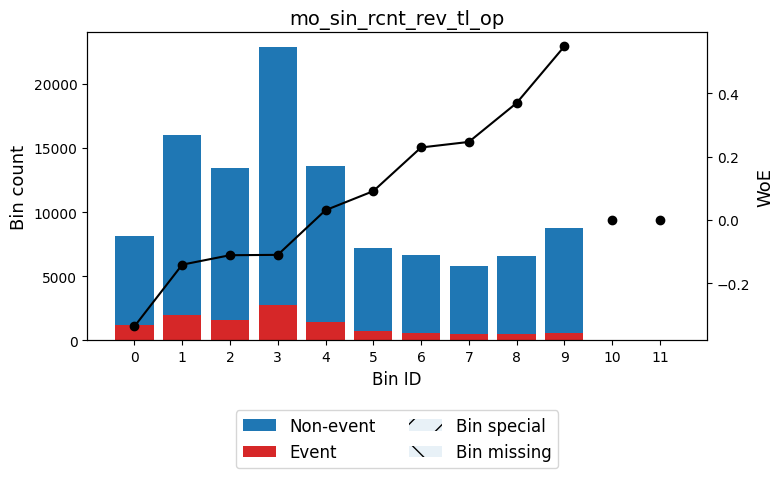

✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0499

🔍 Feature: mo_sin_rcnt_tl
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50)   │   10311 │             0.1438 │ -0.320118152801937   │ 0.0109884   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50)   │   11449 │             0.1239 │ -0.14754670824921967 │ 0.00242505  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50)   │   11043 │             0.1224 │ -0.1343669359089914  │ 0.00192993  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 6.50)   │   28682 │             0.1209 │ -0.11983018921482991 │ 0.00396421  │
├────────────────┼─────────┼────────────────────┼─────────

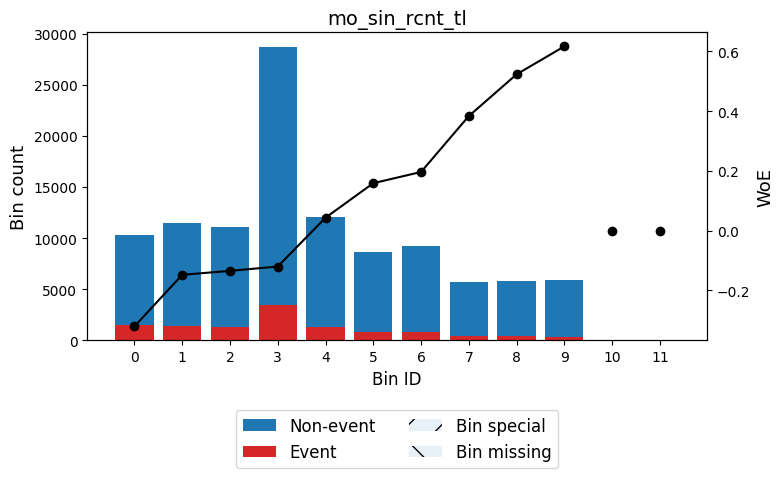

✅ Total IV for mo_sin_rcnt_tl: 0.0591

🔍 Feature: mort_acc
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   44267 │             0.1179 │ -0.10450730016835141 │ 0.0046286   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   21456 │             0.1071 │ 0.0039582741899018   │ 3.08447e-06 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   15971 │             0.1009 │ 0.07038107820824857  │ 0.000707177 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 4.50) │   18338 │             0.0949 │ 0.13755191413553725  │ 0.00302059  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.5

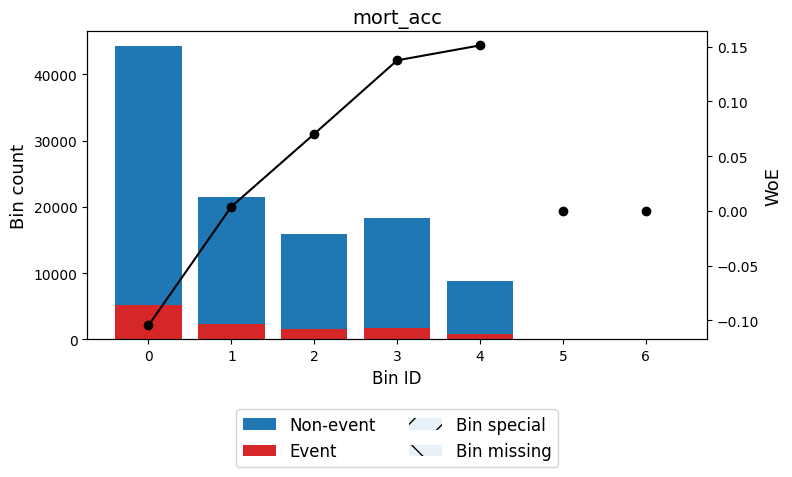

✅ Total IV for mort_acc: 0.0101

🔍 Feature: mths_since_recent_bc
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 2.50)   │    8930 │             0.1366 │ -0.2730689272497726   │ 0.00680352  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 5.50)   │   14445 │             0.1218 │ -0.14162987207866107  │ 0.00281325  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 7.50)   │    8232 │             0.1182 │ -0.10712298098101014  │ 0.000904902 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 9.50)   │    7372 │             0.1176 │ -0.10144884191378178  │ 0.000725182 │
├────────────────┼─────────┼────────────────────┼──────

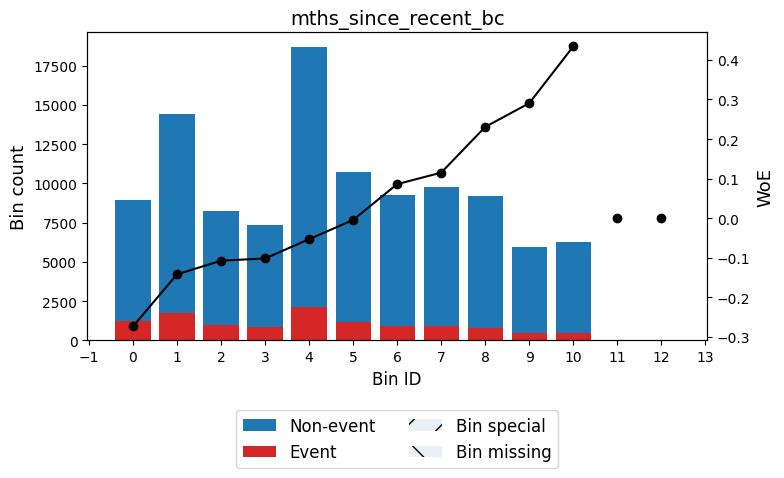

✅ Total IV for mths_since_recent_bc: 0.0309

🔍 Feature: mths_since_recent_inq
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50)   │    8062 │             0.144  │ -0.33482575529428193 │ 0.00946103  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50)   │   10144 │             0.1428 │ -0.3253358967492912  │ 0.0111982   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50)   │    8407 │             0.1269 │ -0.18872251091018422 │ 0.00296226  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50)   │    7677 │             0.1257 │ -0.17768623440893605 │ 0.00238765  │
├────────────────┼─────────┼────────────────────┼───

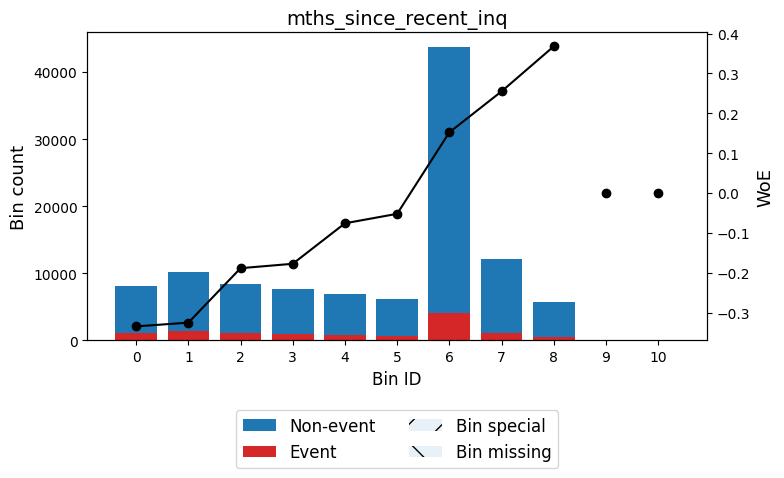

✅ Total IV for mths_since_recent_inq: 0.0479

🔍 Feature: num_accts_ever_120_pd
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   84804 │             0.1037 │ 0.035795523873215274 │ 0.000982841 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   24209 │             0.1188 │ -0.1180470901087256  │ 0.00324123  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─

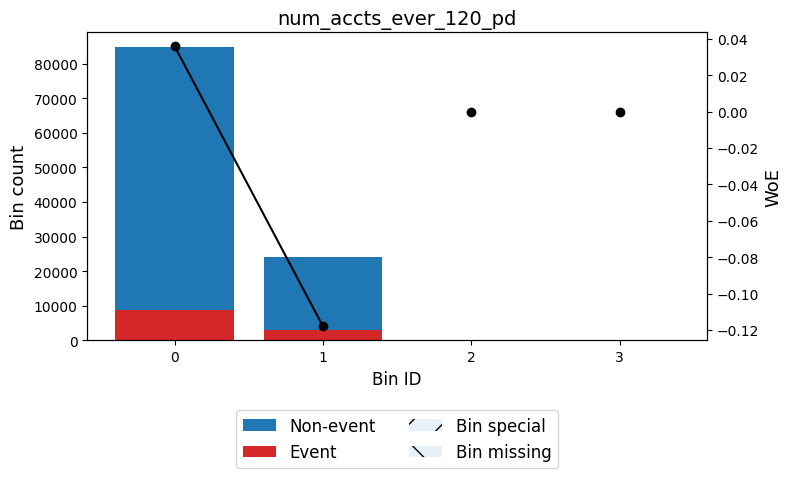

✅ Total IV for num_accts_ever_120_pd: 0.0042

🔍 Feature: num_actv_bc_tl
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50) │   14770 │             0.0944 │ 0.14328249629174916  │ 0.00263387  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 2.50) │   21271 │             0.1007 │ 0.07225515492796708  │ 0.00099195  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 5.50) │   54189 │             0.1106 │ -0.03308917916319487 │ 0.000552353 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 7.50) │   11825 │             0.1146 │ -0.07249781066621086 │ 0.000587611 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────

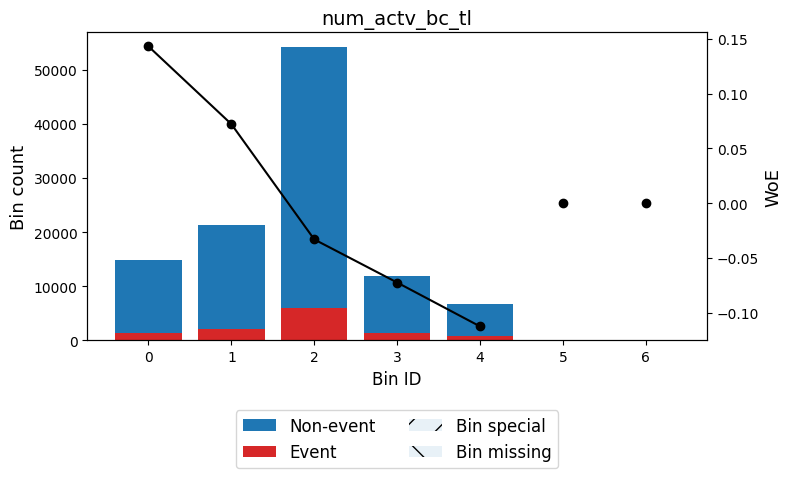

✅ Total IV for num_actv_bc_tl: 0.0056

🔍 Feature: num_bc_sats
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │    8327 │             0.1064 │ 0.024063998751548077  │ 4.3877e-05  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   14722 │             0.105  │ 0.03874646466947684   │ 0.000199961 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 3.50) │   17989 │             0.1055 │ 0.03347983124864484   │ 0.000182804 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, inf)  │   67829 │             0.1106 │ -0.019819008627619095 │ 0.000246632 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼───────

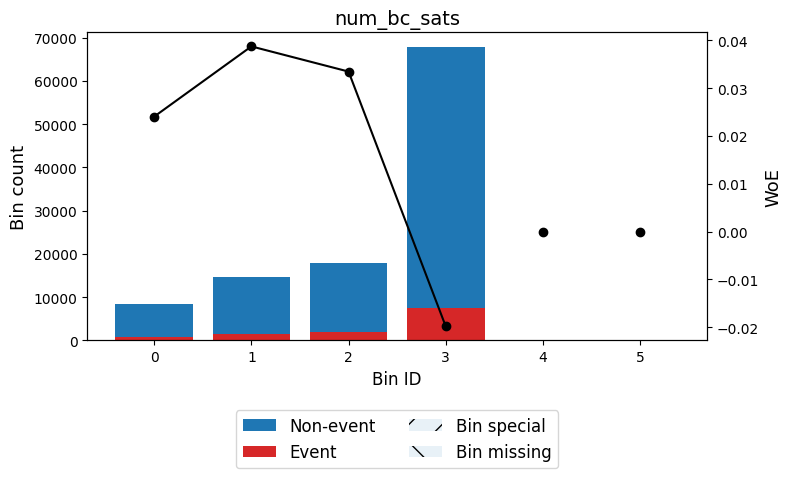

✅ Total IV for num_bc_sats: 0.0007

🔍 Feature: num_bc_tl
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2.50)   │    8344 │             0.0964 │ 0.12116781060604298  │ 0.00107339  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 5.50)   │   30445 │             0.0978 │ 0.10526759790761853  │ 0.00297461  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 6.50)   │   10627 │             0.1044 │ 0.03251565311369653  │ 0.00010194  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [6.50, 9.50)   │   29376 │             0.112  │ -0.04669917404618129 │ 0.0005996   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─

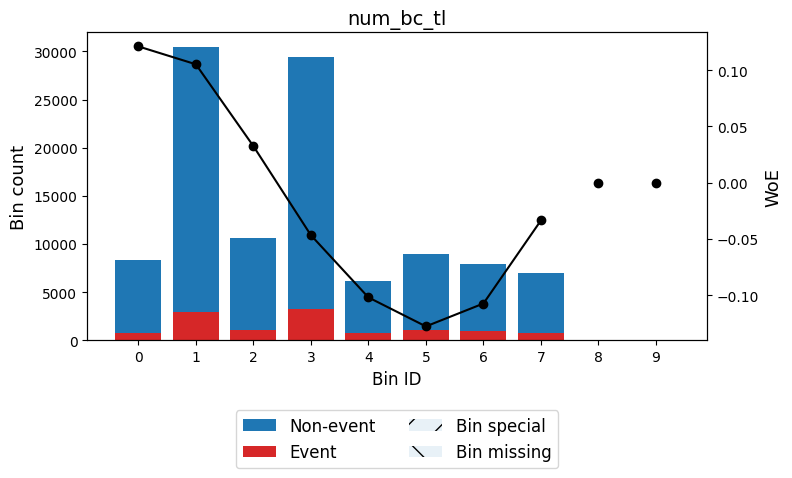

✅ Total IV for num_bc_tl: 0.0077

🔍 Feature: num_il_tl
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50)  │    9729 │             0.0932 │ 0.17088185250911625  │ 0.00244043  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 3.50)  │   17360 │             0.0959 │ 0.1395374888208778   │ 0.00293955  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50)  │   17902 │             0.1045 │ 0.04407172237495205  │ 0.000313929 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 6.50)  │    7844 │             0.1053 │ 0.03565920458155025  │ 9.03486e-05 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤

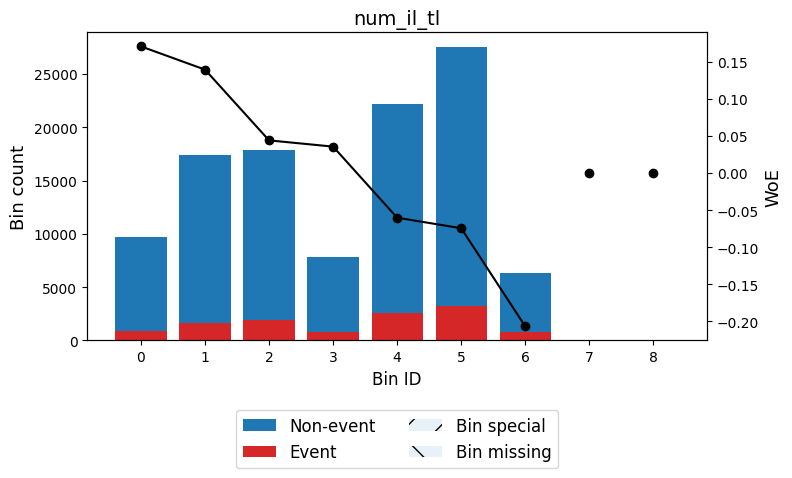

✅ Total IV for num_il_tl: 0.0107

🔍 Feature: num_sats
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 5.50)   │   10087 │             0.0762 │ 0.3906327448304663    │ 0.0121305   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 6.50)   │    6842 │             0.0896 │ 0.21462657127730234   │ 0.00266133  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.50, 7.50)   │    8068 │             0.0994 │ 0.09987302687400046   │ 0.000710837 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 8.50)   │    8683 │             0.1076 │ 0.011863065494475578  │ 1.11725e-05 │
├────────────────┼─────────┼────────────────────┼─────────────────

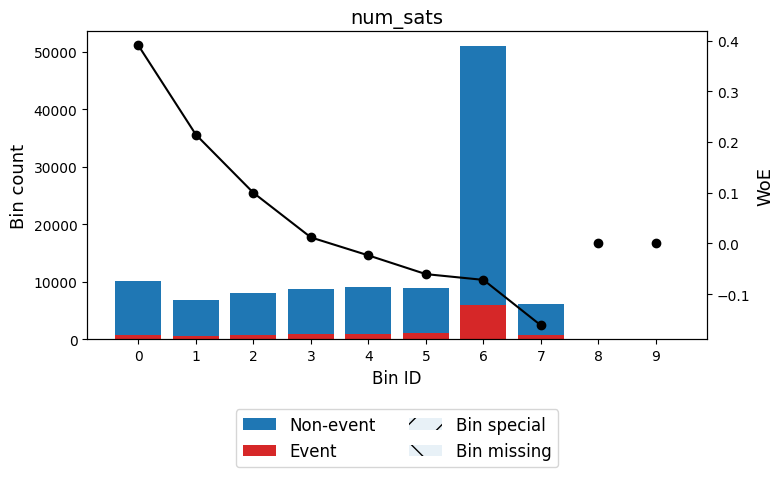

✅ Total IV for num_sats: 0.0199

🔍 Feature: num_tl_120dpd_2m
╒═════════════╤═════════╤════════════════════╤═══════════════════════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE                   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════════════════════╪══════╡
│ (-inf, inf) │  109077 │             0.1081 │ 4.440892098500626e-16 │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Special     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│ Missing     │       0 │             0      │ 0.0                   │    0 │
├─────────────┼─────────┼────────────────────┼───────────────────────┼──────┤
│             │  109077 │             0.1081 │                       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════════════════════╧══════╛


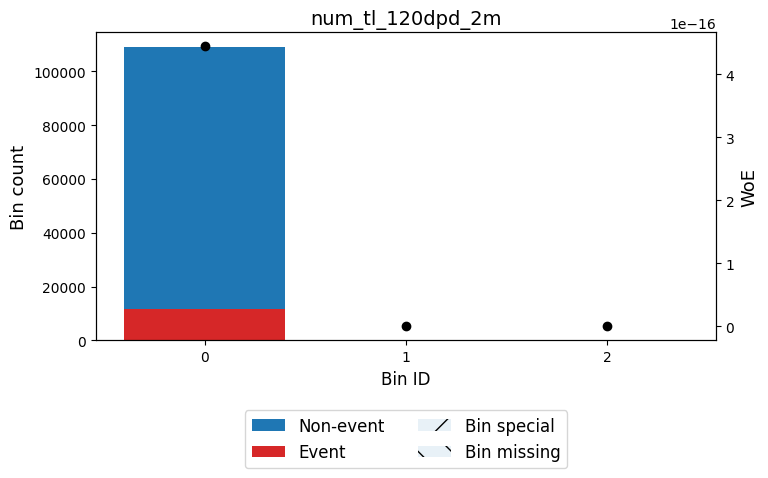

✅ Total IV for num_tl_120dpd_2m: 0.0000

🔍 Feature: num_tl_90g_dpd_24m
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │  103213 │             0.1064 │ 0.013465182274078114 │ 0.000170856 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │    5739 │             0.1309 │ -0.22098510895423762 │ 0.00280401  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────

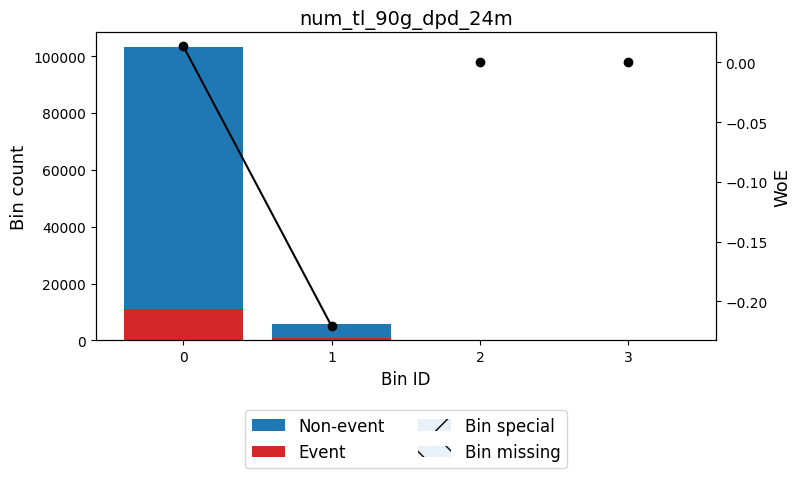

✅ Total IV for num_tl_90g_dpd_24m: 0.0030

🔍 Feature: num_tl_op_past_12m
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   20150 │             0.0719 │ 0.4544675980090984   │ 0.0319907  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   26921 │             0.0898 │ 0.2123296897684961   │ 0.0102578  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   26678 │             0.115  │ -0.06370335841215491 │ 0.00101952 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 3.50) │   15938 │             0.1271 │ -0.17672562373939482 │ 0.0048983  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [

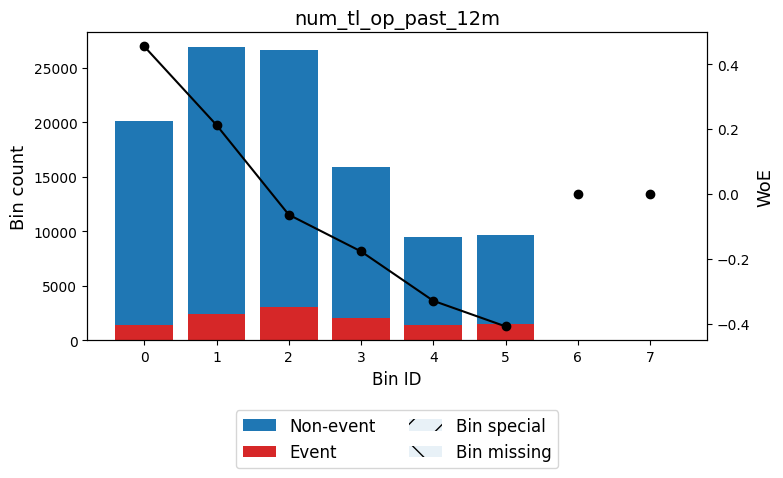

✅ Total IV for num_tl_op_past_12m: 0.0762

🔍 Feature: pct_tl_nvr_dlq
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 75.65)  │    5511 │             0.1007 │ 0.07264987292275293  │ 0.000259664 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [75.65, 89.65) │   16404 │             0.1152 │ -0.07760124712262506 │ 0.000935415 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [89.65, 94.95) │   16313 │             0.1154 │ -0.0802931329690817  │ 0.000996932 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [94.95, 96.15) │    5835 │             0.1258 │ -0.17805340677143477 │ 0.00182173  │
├────────────────┼─────────┼────────────────────┼────────────

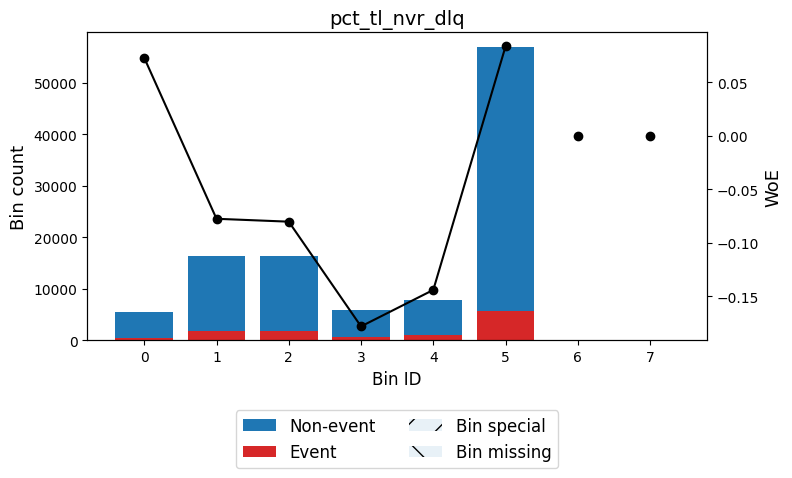

✅ Total IV for pct_tl_nvr_dlq: 0.0091

🔍 Feature: pub_rec_bankruptcies
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   95944 │             0.105  │ 0.028950634921605545 │ 0.000729733 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   13008 │             0.128  │ -0.1955940738455315  │ 0.00493017  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────

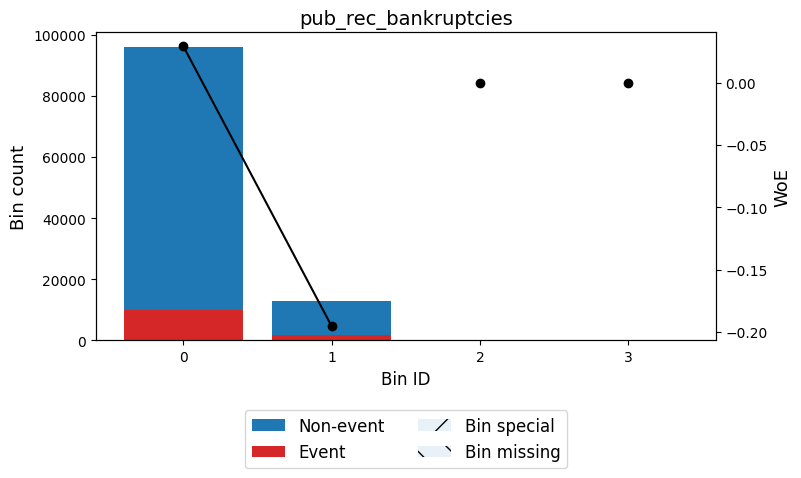

✅ Total IV for pub_rec_bankruptcies: 0.0057

🔍 Feature: tax_liens
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  109191 │             0.1088 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  109191 │             0.1088 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


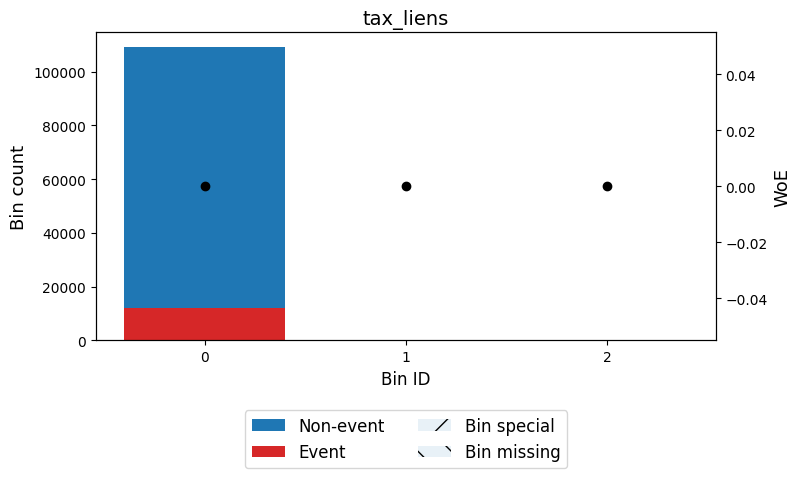

✅ Total IV for tax_liens: 0.0000

🔍 Feature: tot_hi_cred_lim
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 23816.50)       │    7641 │             0.1078 │ 0.009488013237021864 │ 6.29223e-06 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23816.50, 36859.00)   │    8609 │             0.1199 │ -0.10989755232642628 │ 0.000996495 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [36859.00, 60161.00)   │   15514 │             0.1234 │ -0.14264172850504764 │ 0.00306404  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [60161.00, 112798.00)  │   20257 │             0.1255 │ -0.1620556626661187  │ 0.0

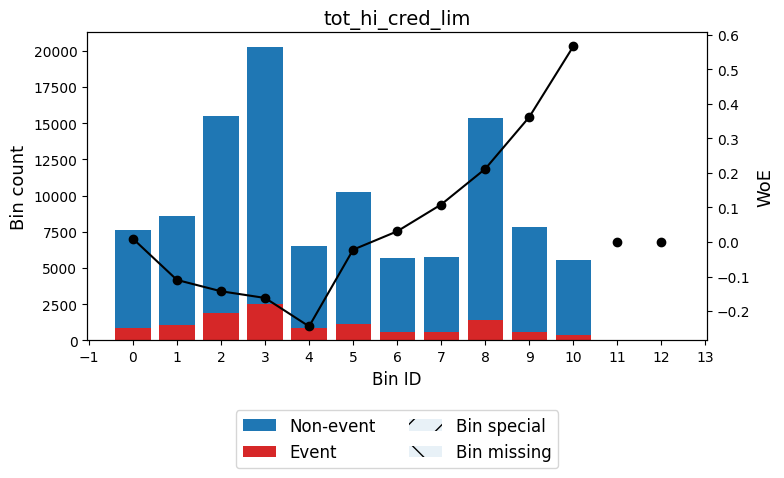

✅ Total IV for tot_hi_cred_lim: 0.0409

🔍 Feature: total_bal_ex_mort
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 8415.50)       │    7548 │             0.0791 │ 0.3379874436280379   │ 0.00693443  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8415.50, 15964.50)   │   10917 │             0.0993 │ 0.0883499167007189   │ 0.00075604  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [15964.50, 23143.50)  │   11748 │             0.1049 │ 0.027522785676461048 │ 8.08654e-05 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23143.50, 37750.50)  │   22722 │             0.1107 │ -0.03297998060018914 │ 0.000

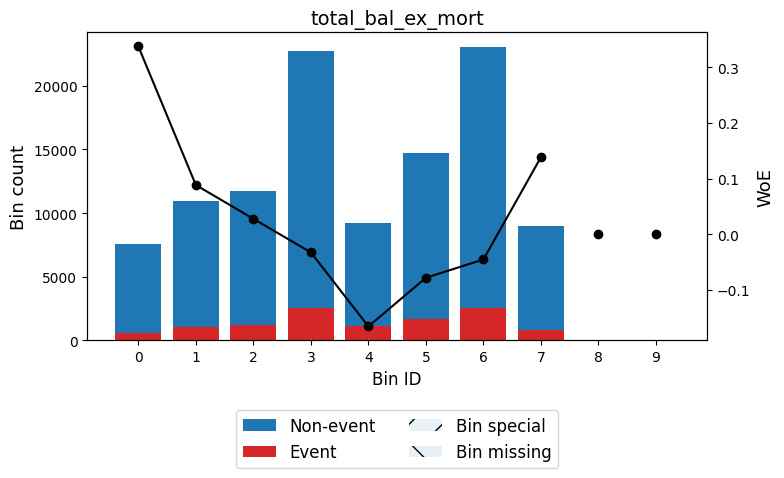

✅ Total IV for total_bal_ex_mort: 0.0133

🔍 Feature: credit_history_years
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 13.29)  │   42679 │             0.1181 │ -0.09265656319757376 │ 0.00348816  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [13.29, 14.79) │   10950 │             0.1131 │ -0.04365116816155368 │ 0.000194865 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14.79, 16.96) │   12922 │             0.1066 │ 0.022016420663811154 │ 5.70161e-05 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [16.96, 22.04) │   20716 │             0.1036 │ 0.054425502939816184 │ 0.000551533 │
├────────────────┼─────────┼────────────────────┼───────

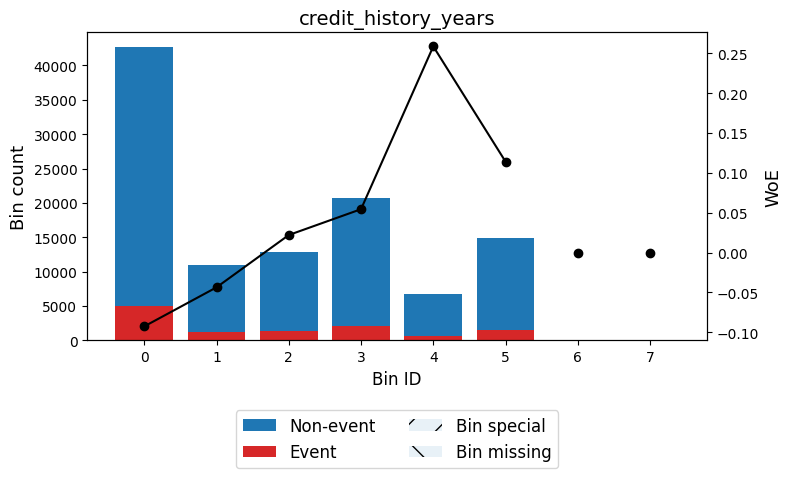

✅ Total IV for credit_history_years: 0.0097

🔍 Feature: fico_score
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 664.50)   │    8683 │             0.16   │ -0.45826822746556384 │ 0.0199987   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [664.50, 674.50) │   17210 │             0.146  │ -0.3501040745791184  │ 0.0222015   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [674.50, 679.50) │    7927 │             0.1338 │ -0.2493664206761914  │ 0.0049905   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [679.50, 684.50) │    7915 │             0.1258 │ -0.17845698416563294 │ 0.00248272  │
├──────────────────┼─────────┼─────────────

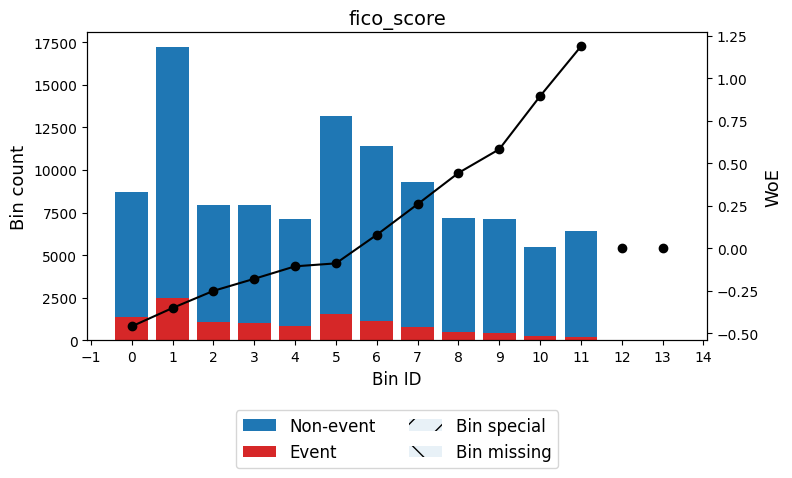

✅ Total IV for fico_score: 0.1669

🔍 Feature: proportion_satisfac_accounts
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.86) │   19581 │             0.0887 │ 0.21277157392720492   │ 0.00748903  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.86, 0.88) │    8172 │             0.0985 │ 0.09718731318440454   │ 0.000682444 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.88, 0.89) │    8736 │             0.1041 │ 0.03625322354751326   │ 0.000103975 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.89, 0.92) │   17939 │             0.1106 │ -0.03207900521231988  │ 0.000171717 │
├──────────────┼─────────┼────────────────────┼──────────────────

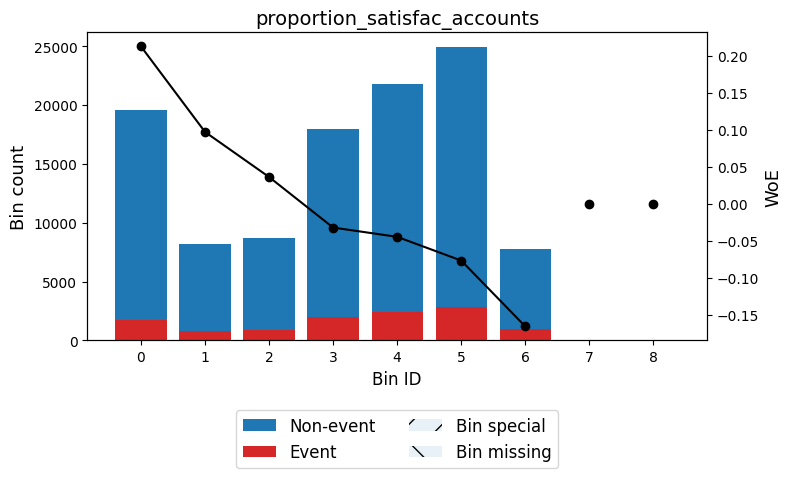

✅ Total IV for proportion_satisfac_accounts: 0.0123

🔍 Feature: proportion_satisfac_bc_tl
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.55) │    7738 │             0.1058 │ 0.017206189565896146  │ 2.09012e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.55, 0.68) │   11159 │             0.107  │ 0.005033682614501878  │ 2.59207e-06 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.68, 0.76) │   11448 │             0.109  │ -0.015890805736856084 │ 2.67201e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.76, 0.85) │   13879 │             0.1148 │ -0.07460383047472652  │ 0.000730614 │
├──────────────┼─────────┼────────────────────┼───

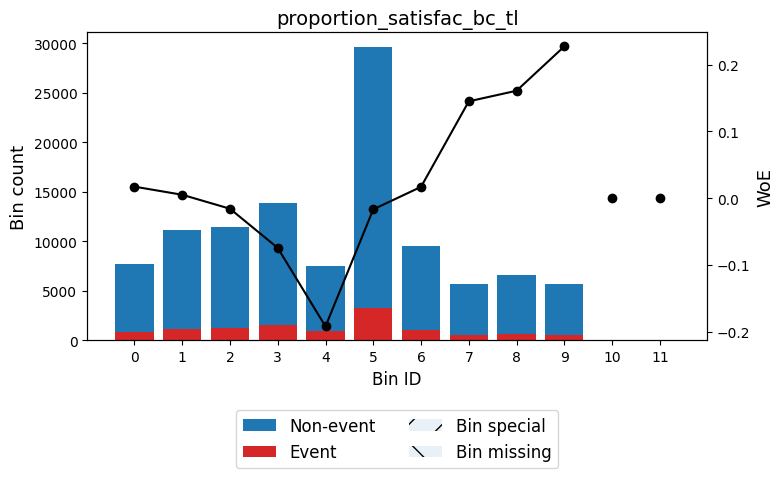

✅ Total IV for proportion_satisfac_bc_tl: 0.0086


In [ ]:
from optbinning import OptimalBinning
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType
import pandas as pd
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# =========================
# Set-up Constants
# =========================

TARGET_COL = "default_status"
SAMPLE_FRAC = 0.05
SEED = 42

IV_THRESHOLDS = {
    "useless": 0.02,
    "weak": 0.1,
    "medium": 0.3,
    "strong": 0.5,
}

# Feature classification containers
iv_categories = {
    "useless": [],
    "weak": [],
    "medium": [],
    "strong": [],
    "suspicious": [],
    "no_variation": [],
}

# =========================
# Helper Functions
# =========================

def get_numerical_cols(df, target_col):
    return [
        f.name for f in df.schema.fields
        if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))
        and f.name != target_col
    ]

def classify_iv(feature, iv_score):
    for label, threshold in IV_THRESHOLDS.items():
        if iv_score < threshold:
            iv_categories[label].append((feature, iv_score))
            return
    iv_categories["suspicious"].append((feature, iv_score))

def bin_and_classify_feature(feature, x, y, dtype="numerical", interaction="base", ws=None, wb=None, output_path=None):
    optb = OptimalBinning(
        name=feature,
        dtype=dtype,
        monotonic_trend="auto",
        solver="cp"
    )
    optb.fit(x, y)
    binning_table = optb.binning_table

    bin_table = optb.binning_table.build()
    bin_df = pd.DataFrame({
        "Bin": bin_table["Bin"],
        "Count": round(bin_table["Count"], 4),
        "Default Rate (%)": round(bin_table["Event rate"], 4),
        "WOE": bin_table["WoE"],
        "IV": bin_table["IV"]
    })

    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))
    # 📊 Add plot here:
    
    binning_table.plot(metric="woe", figsize=(8,4)) 
    

    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv:.4f}")

    if ws and wb and output_path:
        existing_features = [cell.value for cell in ws["A"] if cell.value]
        if feature not in existing_features:
            ws.append([feature, total_iv, interaction])
            wb.save(output_path)

    classify_iv(feature, total_iv)

# =========================
# Main Execution
# =========================

numerical_cols = get_numerical_cols(df, TARGET_COL)

for feature in numerical_cols:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")
    sample_df = (
        df.select(feature, TARGET_COL)
        .sample(fraction=SAMPLE_FRAC, seed=SEED)
        .toPandas()
    )

    if sample_df[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = sample_df[feature], sample_df[TARGET_COL]
    bin_and_classify_feature(feature, x, y, ws=ws, wb=wb, output_path=output_path)



In [ ]:
for key, val in iv_categories.items():
    print(f"\n{key.capitalize()} Features ({len(val)}):")
    for feature, iv in val:
        print(f" - {feature}: {iv:.4f}")